In [1]:
import numpy as np
import mxnet as mx
import time
import pandas as pd

import cv2

import logging
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data0 = pd.read_csv('complete_hand_data_clean.csv')#, names=['name','state'])

In [4]:
data0.head()

,name,state
0,data/xrdata1/hand_xrpic/a_232bf02f_0_lc.jpg,0
1,data/xrdata1/hand_xrpic/a_232bf02f_1_lo.jpg,1
2,data/xrdata1/hand_xrpic/a_232bf02f_2_lq.jpg,2
3,data/xrdata1/hand_xrpic/a_232bf02f_3_lw.jpg,3
4,data/xrdata1/hand_xrpic/a_232bf02f_4_le.jpg,4


In [5]:
num_class = len(data0['state'].unique())

In [6]:
import json
with open('num2ges.json') as fin:
    num_to_ges = json.load(fin, encoding='latin')
num_to_ges

{u'0': u' lc',
 u'1': u' lo',
 u'10': u' mc',
 u'11': u' mo',
 u'12': u' mq',
 u'13': u' mw',
 u'14': u' me',
 u'15': u' m1',
 u'16': u' m2',
 u'17': u' m3',
 u'18': u' m4',
 u'19': u' m5',
 u'2': u' lq',
 u'20': u' rc',
 u'21': u' ro',
 u'22': u' rq',
 u'23': u' rw',
 u'24': u' re',
 u'25': u' r1',
 u'26': u' r2',
 u'27': u' r3',
 u'28': u' r4',
 u'29': u' r5',
 u'3': u' lw',
 u'30': u'vc',
 u'31': u'vo',
 u'32': u'vq',
 u'33': u'vw',
 u'34': u've',
 u'35': u'v1',
 u'36': u'v2',
 u'37': u'v3',
 u'38': u'v4',
 u'39': u'v5',
 u'4': u' le',
 u'5': u' l1',
 u'6': u' l2',
 u'7': u' l3',
 u'8': u' l4',
 u'9': u' l5'}

In [7]:
# data0 = data0.replace({'state':ges_to_num})

In [8]:
data0.shape

(4320, 2)

In [9]:
import os

models_path = 'models'
if not os.path.exists(models_path):
    os.makedirs(models_path)

labels = np.empty((data0.shape[0]))

# res_width, res_height = 200, 200
res_width, res_height = 64, 64

imgs = np.empty(shape=(data0.shape[0],3, res_width,res_height))
imgs.shape, labels.shape

((4320, 3, 64, 64), (4320,))

In [10]:

for i, (im_path, state) in enumerate(data0.values):
#     im_path = prefix + im_name
#     print im_path
    img = cv2.imread(im_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    res = cv2.resize(gray,(res_width, res_height), interpolation=cv2.INTER_CUBIC)

    res = np.swapaxes(res, 0, 2)
    res = np.swapaxes(res, 1, 2)
    res = res[np.newaxis, :]

    imgs[i] = res
    labels[i] = state

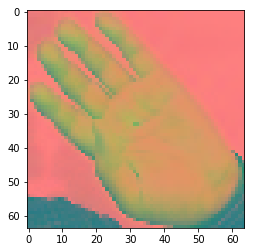

In [11]:
plt.imshow(gray)

In [12]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_label, test_label = train_test_split(imgs, labels, test_size=0.1, shuffle=True)

In [13]:
# train_data, train_label = imgs, labels
# test_data, test_label = imgs[23:], labels[2:]
train_data.shape, train_label.shape, test_data.shape, test_label.shape

((3888, 3, 64, 64), (3888,), (432, 3, 64, 64), (432,))

In [14]:
test_label

array([22., 26., 26., 34.,  7., 39., 39., 30.,  8., 31., 32.,  3., 14.,
       38., 35., 39., 30., 31., 32., 31., 35.,  5., 38., 21., 37., 21.,
       27.,  8., 36.,  1., 13., 14., 38., 31., 14., 35.,  3., 39.,  2.,
       32., 32., 37., 31., 39., 32., 37., 31., 35., 31.,  0.,  1., 14.,
       37., 32., 20., 30., 30., 38.,  6., 31., 37.,  9., 39., 32., 38.,
        5., 18.,  8., 24., 28., 14.,  4., 35.,  9., 35., 27.,  7., 19.,
       34.,  0., 31., 11., 33., 35., 38., 32., 34., 32., 35.,  8., 19.,
       24., 19.,  6.,  9., 36., 37.,  5., 36., 27., 32.,  0.,  1., 34.,
        5.,  2., 32., 36., 30., 37., 31., 33.,  9.,  3., 37., 30., 29.,
       32., 26., 15., 31., 21., 38., 17., 24., 38., 11., 30., 23., 37.,
       17., 30., 35., 34., 11., 25.,  7.,  9., 16., 30., 13., 22.,  4.,
       32., 16., 37.,  2.,  4., 34., 23., 13., 34.,  3., 14., 15.,  2.,
       35., 35., 24., 16., 25., 33., 39., 17., 37., 35.,  4., 14., 35.,
       37., 19., 14., 30., 36., 33., 31., 37., 34., 17.,  2., 38

In [15]:
batch_size = 128
train_iter = mx.io.NDArrayIter(train_data, train_label, batch_size, shuffle=True)
eval_iter = mx.io.NDArrayIter(test_data, test_label, batch_size)

In [22]:
data = mx.sym.var('data')

conv1 = mx.sym.Convolution(data=data, kernel=(5,5), num_filter=20, name='conv1')
bn1 = mx.sym.BatchNorm(conv1, fix_gamma=True)
tanh1 = mx.sym.Activation(data=bn1, act_type='relu')
pool1 = mx.sym.Pooling(data=tanh1, pool_type='max', kernel=(2,2), stride=(2,2))

conv2 = mx.sym.Convolution(data=pool1, kernel=(5,5), num_filter=50, name='conv2')
bn2 = mx.sym.BatchNorm(conv2, fix_gamma=True)
tanh2 = mx.sym.Activation(data=bn2, act_type='relu')
pool2 = mx.sym.Pooling(data=tanh2, pool_type='max', kernel=(2,2), stride=(2,2))

flat = mx.sym.flatten(data=pool2)
fc1 = mx.sym.FullyConnected(data=flat, num_hidden=512)
tanh3 = mx.sym.Activation(data=fc1, act_type='relu')

drop = mx.symbol.Dropout(tanh3, p=0.5)
fc2 = mx.sym.FullyConnected(data=drop, num_hidden=num_class)

convnet = mx.sym.SoftmaxOutput(data=fc2, name='softmax')

#mx.viz.plot_network(convnet)

In [23]:
model = mx.mod.Module(symbol=convnet, context=mx.cpu())

In [24]:
model.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
model.init_params(initializer=mx.init.Uniform(scale=.01))
model.init_optimizer(optimizer='sgd', optimizer_params={'learning_rate':0.001, 'wd': 0.001})

metric = mx.metric.Accuracy()

In [25]:
chk_prefix='models/chkpt'
for epoch in range(400):
    train_iter.reset()
    metric.reset()
    
    st = time.time()
    for batch in train_iter:
        model.forward(data_batch=batch, is_train=True)
        model.update_metric(metric, batch.label)
        model.backward()
        model.update()
    
    if epoch % 30 == 0:
#         model_path = '{}_{}'.format(chk_prefix, epoch)
        model.save_checkpoint(chk_prefix, epoch)
        
    et = time.time()-st
    print('Epoch %d, Training %s, Time %.2f' % (epoch, metric.get(), et))

INFO:root:Saved checkpoint to "models/chkpt-0000.params"


Epoch 0, Training ('accuracy', 0.047379032258064516), Time 19.90
Epoch 1, Training ('accuracy', 0.06854838709677419), Time 24.87
Epoch 2, Training ('accuracy', 0.07182459677419355), Time 25.08
Epoch 3, Training ('accuracy', 0.08568548387096774), Time 25.19
Epoch 4, Training ('accuracy', 0.0859375), Time 25.07
Epoch 5, Training ('accuracy', 0.09400201612903226), Time 25.00
Epoch 6, Training ('accuracy', 0.11164314516129033), Time 25.01
Epoch 7, Training ('accuracy', 0.10257056451612903), Time 25.41
Epoch 8, Training ('accuracy', 0.1028225806451613), Time 25.73
Epoch 9, Training ('accuracy', 0.11189516129032258), Time 25.11
Epoch 10, Training ('accuracy', 0.12247983870967742), Time 26.02
Epoch 11, Training ('accuracy', 0.13079637096774194), Time 25.52
Epoch 12, Training ('accuracy', 0.13785282258064516), Time 26.75
Epoch 13, Training ('accuracy', 0.14969758064516128), Time 27.65
Epoch 14, Training ('accuracy', 0.1622983870967742), Time 25.62
Epoch 15, Training ('accuracy', 0.182207661290

INFO:root:Saved checkpoint to "models/chkpt-0030.params"


Epoch 30, Training ('accuracy', 0.4067540322580645), Time 25.77
Epoch 31, Training ('accuracy', 0.4319556451612903), Time 25.04
Epoch 32, Training ('accuracy', 0.4458165322580645), Time 25.22
Epoch 33, Training ('accuracy', 0.4654737903225806), Time 25.22
Epoch 34, Training ('accuracy', 0.47076612903225806), Time 25.21
Epoch 35, Training ('accuracy', 0.4909274193548387), Time 25.38
Epoch 36, Training ('accuracy', 0.5073084677419355), Time 25.21
Epoch 37, Training ('accuracy', 0.5418346774193549), Time 25.24
Epoch 38, Training ('accuracy', 0.5486391129032258), Time 25.37
Epoch 39, Training ('accuracy', 0.5577116935483871), Time 25.22
Epoch 40, Training ('accuracy', 0.5720766129032258), Time 25.36
Epoch 41, Training ('accuracy', 0.5839213709677419), Time 25.27
Epoch 42, Training ('accuracy', 0.6113911290322581), Time 25.26
Epoch 43, Training ('accuracy', 0.6078629032258065), Time 25.23
Epoch 44, Training ('accuracy', 0.6242439516129032), Time 25.24
Epoch 45, Training ('accuracy', 0.64717

INFO:root:Saved checkpoint to "models/chkpt-0060.params"


Epoch 60, Training ('accuracy', 0.7709173387096774), Time 25.72
Epoch 61, Training ('accuracy', 0.7709173387096774), Time 24.71
Epoch 62, Training ('accuracy', 0.7837701612903226), Time 25.30
Epoch 63, Training ('accuracy', 0.7941028225806451), Time 25.11
Epoch 64, Training ('accuracy', 0.7976310483870968), Time 25.24
Epoch 65, Training ('accuracy', 0.7986391129032258), Time 25.10
Epoch 66, Training ('accuracy', 0.8044354838709677), Time 25.10
Epoch 67, Training ('accuracy', 0.8079637096774194), Time 25.10
Epoch 68, Training ('accuracy', 0.8167842741935484), Time 25.20
Epoch 69, Training ('accuracy', 0.8182963709677419), Time 25.26
Epoch 70, Training ('accuracy', 0.821320564516129), Time 25.12
Epoch 71, Training ('accuracy', 0.8331653225806451), Time 25.10
Epoch 72, Training ('accuracy', 0.8336693548387096), Time 25.12
Epoch 73, Training ('accuracy', 0.8339213709677419), Time 25.26
Epoch 74, Training ('accuracy', 0.8336693548387096), Time 25.09
Epoch 75, Training ('accuracy', 0.8503024

INFO:root:Saved checkpoint to "models/chkpt-0090.params"


Epoch 90, Training ('accuracy', 0.9024697580645161), Time 25.67
Epoch 91, Training ('accuracy', 0.9059979838709677), Time 24.67
Epoch 92, Training ('accuracy', 0.9049899193548387), Time 25.37
Epoch 93, Training ('accuracy', 0.9024697580645161), Time 25.16
Epoch 94, Training ('accuracy', 0.9077620967741935), Time 25.19
Epoch 95, Training ('accuracy', 0.9087701612903226), Time 25.16
Epoch 96, Training ('accuracy', 0.9110383064516129), Time 25.15
Epoch 97, Training ('accuracy', 0.9148185483870968), Time 25.55
Epoch 98, Training ('accuracy', 0.9206149193548387), Time 25.14
Epoch 99, Training ('accuracy', 0.9155745967741935), Time 25.18
Epoch 100, Training ('accuracy', 0.9183467741935484), Time 25.17
Epoch 101, Training ('accuracy', 0.9203629032258065), Time 25.22
Epoch 102, Training ('accuracy', 0.9185987903225806), Time 25.30
Epoch 103, Training ('accuracy', 0.9180947580645161), Time 25.20
Epoch 104, Training ('accuracy', 0.9221270161290323), Time 25.99
Epoch 105, Training ('accuracy', 0.

INFO:root:Saved checkpoint to "models/chkpt-0120.params"


Epoch 120, Training ('accuracy', 0.9382560483870968), Time 25.80
Epoch 121, Training ('accuracy', 0.9438004032258065), Time 24.65
Epoch 122, Training ('accuracy', 0.9453125), Time 25.19
Epoch 123, Training ('accuracy', 0.9430443548387096), Time 25.16
Epoch 124, Training ('accuracy', 0.9445564516129032), Time 25.20
Epoch 125, Training ('accuracy', 0.9448084677419355), Time 25.31
Epoch 126, Training ('accuracy', 0.946320564516129), Time 25.17
Epoch 127, Training ('accuracy', 0.9498487903225806), Time 25.18
Epoch 128, Training ('accuracy', 0.9478326612903226), Time 25.17
Epoch 129, Training ('accuracy', 0.9526209677419355), Time 25.17
Epoch 130, Training ('accuracy', 0.9460685483870968), Time 25.28
Epoch 131, Training ('accuracy', 0.9506048387096774), Time 25.20
Epoch 132, Training ('accuracy', 0.9558971774193549), Time 25.18
Epoch 133, Training ('accuracy', 0.9528729838709677), Time 25.93
Epoch 134, Training ('accuracy', 0.954133064516129), Time 34.22
Epoch 135, Training ('accuracy', 0.9

INFO:root:Saved checkpoint to "models/chkpt-0150.params"


Epoch 150, Training ('accuracy', 0.9589213709677419), Time 26.60
Epoch 151, Training ('accuracy', 0.9674899193548387), Time 24.82
Epoch 152, Training ('accuracy', 0.9627016129032258), Time 26.04
Epoch 153, Training ('accuracy', 0.9604334677419355), Time 25.64
Epoch 154, Training ('accuracy', 0.9634576612903226), Time 25.22
Epoch 155, Training ('accuracy', 0.9647177419354839), Time 25.27
Epoch 156, Training ('accuracy', 0.9674899193548387), Time 25.26
Epoch 157, Training ('accuracy', 0.9662298387096774), Time 25.36
Epoch 158, Training ('accuracy', 0.9652217741935484), Time 25.30
Epoch 159, Training ('accuracy', 0.9674899193548387), Time 25.28
Epoch 160, Training ('accuracy', 0.9649697580645161), Time 25.27
Epoch 161, Training ('accuracy', 0.9634576612903226), Time 25.38
Epoch 162, Training ('accuracy', 0.9679939516129032), Time 25.24
Epoch 163, Training ('accuracy', 0.9667338709677419), Time 25.26
Epoch 164, Training ('accuracy', 0.9690020161290323), Time 25.24
Epoch 165, Training ('acc

INFO:root:Saved checkpoint to "models/chkpt-0180.params"


Epoch 180, Training ('accuracy', 0.9725302419354839), Time 25.88
Epoch 181, Training ('accuracy', 0.9753024193548387), Time 24.68
Epoch 182, Training ('accuracy', 0.9737903225806451), Time 25.17
Epoch 183, Training ('accuracy', 0.9747983870967742), Time 25.25
Epoch 184, Training ('accuracy', 0.9785786290322581), Time 25.18
Epoch 185, Training ('accuracy', 0.9758064516129032), Time 25.30
Epoch 186, Training ('accuracy', 0.9768145161290323), Time 25.15
Epoch 187, Training ('accuracy', 0.9753024193548387), Time 25.21
Epoch 188, Training ('accuracy', 0.9770665322580645), Time 25.16
Epoch 189, Training ('accuracy', 0.9737903225806451), Time 25.15
Epoch 190, Training ('accuracy', 0.9725302419354839), Time 25.29
Epoch 191, Training ('accuracy', 0.9763104838709677), Time 25.19
Epoch 192, Training ('accuracy', 0.9785786290322581), Time 25.19
Epoch 193, Training ('accuracy', 0.9763104838709677), Time 25.27
Epoch 194, Training ('accuracy', 0.9765625), Time 25.31
Epoch 195, Training ('accuracy', 0

INFO:root:Saved checkpoint to "models/chkpt-0210.params"


Epoch 210, Training ('accuracy', 0.9803427419354839), Time 25.79
Epoch 211, Training ('accuracy', 0.9778225806451613), Time 24.72
Epoch 212, Training ('accuracy', 0.9798387096774194), Time 25.25
Epoch 213, Training ('accuracy', 0.9823588709677419), Time 25.28
Epoch 214, Training ('accuracy', 0.9810987903225806), Time 25.34
Epoch 215, Training ('accuracy', 0.9831149193548387), Time 25.23
Epoch 216, Training ('accuracy', 0.9800907258064516), Time 25.24
Epoch 217, Training ('accuracy', 0.9800907258064516), Time 25.24
Epoch 218, Training ('accuracy', 0.9800907258064516), Time 25.37
Epoch 219, Training ('accuracy', 0.9793346774193549), Time 25.18
Epoch 220, Training ('accuracy', 0.9838709677419355), Time 25.20
Epoch 221, Training ('accuracy', 0.9831149193548387), Time 25.20
Epoch 222, Training ('accuracy', 0.9818548387096774), Time 25.20
Epoch 223, Training ('accuracy', 0.983366935483871), Time 25.27
Epoch 224, Training ('accuracy', 0.9823588709677419), Time 25.18
Epoch 225, Training ('accu

INFO:root:Saved checkpoint to "models/chkpt-0240.params"


Epoch 240, Training ('accuracy', 0.9851310483870968), Time 25.75
Epoch 241, Training ('accuracy', 0.9851310483870968), Time 24.78
Epoch 242, Training ('accuracy', 0.9848790322580645), Time 25.32
Epoch 243, Training ('accuracy', 0.9816028225806451), Time 25.22
Epoch 244, Training ('accuracy', 0.9821068548387096), Time 25.22
Epoch 245, Training ('accuracy', 0.9831149193548387), Time 25.21
Epoch 246, Training ('accuracy', 0.9868951612903226), Time 25.22
Epoch 247, Training ('accuracy', 0.985383064516129), Time 25.38
Epoch 248, Training ('accuracy', 0.9861391129032258), Time 25.28
Epoch 249, Training ('accuracy', 0.9856350806451613), Time 25.26
Epoch 250, Training ('accuracy', 0.984375), Time 25.28
Epoch 251, Training ('accuracy', 0.985383064516129), Time 25.28
Epoch 252, Training ('accuracy', 0.9881552419354839), Time 25.38
Epoch 253, Training ('accuracy', 0.9821068548387096), Time 25.29
Epoch 254, Training ('accuracy', 0.9848790322580645), Time 25.27
Epoch 255, Training ('accuracy', 0.98

INFO:root:Saved checkpoint to "models/chkpt-0270.params"


Epoch 270, Training ('accuracy', 0.9884072580645161), Time 25.82
Epoch 271, Training ('accuracy', 0.9881552419354839), Time 24.89
Epoch 272, Training ('accuracy', 0.9863911290322581), Time 25.26
Epoch 273, Training ('accuracy', 0.9861391129032258), Time 25.28
Epoch 274, Training ('accuracy', 0.9866431451612904), Time 25.27
Epoch 275, Training ('accuracy', 0.9866431451612904), Time 25.39
Epoch 276, Training ('accuracy', 0.9868951612903226), Time 25.26
Epoch 277, Training ('accuracy', 0.9866431451612904), Time 25.30
Epoch 278, Training ('accuracy', 0.9879032258064516), Time 25.29
Epoch 279, Training ('accuracy', 0.9866431451612904), Time 25.45
Epoch 280, Training ('accuracy', 0.9884072580645161), Time 25.38
Epoch 281, Training ('accuracy', 0.9879032258064516), Time 25.24
Epoch 282, Training ('accuracy', 0.9889112903225806), Time 25.29
Epoch 283, Training ('accuracy', 0.9886592741935484), Time 25.23
Epoch 284, Training ('accuracy', 0.9879032258064516), Time 25.27
Epoch 285, Training ('acc

INFO:root:Saved checkpoint to "models/chkpt-0300.params"


Epoch 300, Training ('accuracy', 0.9909274193548387), Time 25.72
Epoch 301, Training ('accuracy', 0.9894153225806451), Time 24.69
Epoch 302, Training ('accuracy', 0.9891633064516129), Time 25.24
Epoch 303, Training ('accuracy', 0.9868951612903226), Time 25.27
Epoch 304, Training ('accuracy', 0.9894153225806451), Time 25.36
Epoch 305, Training ('accuracy', 0.9891633064516129), Time 25.31
Epoch 306, Training ('accuracy', 0.9886592741935484), Time 25.28
Epoch 307, Training ('accuracy', 0.9901713709677419), Time 25.30
Epoch 308, Training ('accuracy', 0.9876512096774194), Time 25.34
Epoch 309, Training ('accuracy', 0.9884072580645161), Time 25.38
Epoch 310, Training ('accuracy', 0.9899193548387096), Time 25.29
Epoch 311, Training ('accuracy', 0.9886592741935484), Time 25.30
Epoch 312, Training ('accuracy', 0.9926915322580645), Time 25.33
Epoch 313, Training ('accuracy', 0.9909274193548387), Time 25.53
Epoch 314, Training ('accuracy', 0.9886592741935484), Time 25.28
Epoch 315, Training ('acc

INFO:root:Saved checkpoint to "models/chkpt-0330.params"


Epoch 330, Training ('accuracy', 0.9904233870967742), Time 25.76
Epoch 331, Training ('accuracy', 0.9909274193548387), Time 24.78
Epoch 332, Training ('accuracy', 0.9921875), Time 25.36
Epoch 333, Training ('accuracy', 0.9914314516129032), Time 25.25
Epoch 334, Training ('accuracy', 0.991179435483871), Time 25.29
Epoch 335, Training ('accuracy', 0.9909274193548387), Time 25.26
Epoch 336, Training ('accuracy', 0.9921875), Time 25.32
Epoch 337, Training ('accuracy', 0.9906754032258065), Time 25.42
Epoch 338, Training ('accuracy', 0.9919354838709677), Time 25.26
Epoch 339, Training ('accuracy', 0.9906754032258065), Time 25.26
Epoch 340, Training ('accuracy', 0.9914314516129032), Time 25.26
Epoch 341, Training ('accuracy', 0.9901713709677419), Time 25.24
Epoch 342, Training ('accuracy', 0.9914314516129032), Time 25.38
Epoch 343, Training ('accuracy', 0.991179435483871), Time 25.31
Epoch 344, Training ('accuracy', 0.9924395161290323), Time 25.27
Epoch 345, Training ('accuracy', 0.9936995967

INFO:root:Saved checkpoint to "models/chkpt-0360.params"


Epoch 360, Training ('accuracy', 0.9929435483870968), Time 25.77
Epoch 361, Training ('accuracy', 0.9924395161290323), Time 24.82
Epoch 362, Training ('accuracy', 0.9944556451612904), Time 25.18
Epoch 363, Training ('accuracy', 0.9944556451612904), Time 25.19
Epoch 364, Training ('accuracy', 0.9944556451612904), Time 25.15
Epoch 365, Training ('accuracy', 0.9942036290322581), Time 25.32
Epoch 366, Training ('accuracy', 0.9926915322580645), Time 25.19
Epoch 367, Training ('accuracy', 0.9934475806451613), Time 25.19
Epoch 368, Training ('accuracy', 0.9936995967741935), Time 25.18
Epoch 369, Training ('accuracy', 0.9929435483870968), Time 25.19
Epoch 370, Training ('accuracy', 0.993195564516129), Time 25.28
Epoch 371, Training ('accuracy', 0.993195564516129), Time 25.16
Epoch 372, Training ('accuracy', 0.9924395161290323), Time 25.20
Epoch 373, Training ('accuracy', 0.9909274193548387), Time 25.18
Epoch 374, Training ('accuracy', 0.991179435483871), Time 25.21
Epoch 375, Training ('accura

INFO:root:Saved checkpoint to "models/chkpt-0390.params"


Epoch 390, Training ('accuracy', 0.9916834677419355), Time 25.72
Epoch 391, Training ('accuracy', 0.9926915322580645), Time 24.74
Epoch 392, Training ('accuracy', 0.9921875), Time 25.23
Epoch 393, Training ('accuracy', 0.9914314516129032), Time 25.23
Epoch 394, Training ('accuracy', 0.9924395161290323), Time 25.37
Epoch 395, Training ('accuracy', 0.9921875), Time 25.27
Epoch 396, Training ('accuracy', 0.9947076612903226), Time 25.22
Epoch 397, Training ('accuracy', 0.9914314516129032), Time 25.25
Epoch 398, Training ('accuracy', 0.9921875), Time 25.24
Epoch 399, Training ('accuracy', 0.9936995967741935), Time 25.33


In [26]:
model.score(eval_iter, metric)

[('accuracy', 0.98046875)]

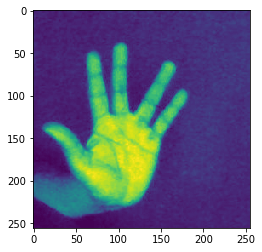

In [28]:
pred_im = cv2.imread('hand2.jpg', 0)
plt.imshow(pred_im)